In [ ]:
import pandas as pd 
import numpy as np 
import torch 
import torch .nn as nn 
import torch .optim as optim 
from torch .utils .data import Dataset ,DataLoader 
from sklearn .preprocessing import LabelEncoder ,StandardScaler 
from sklearn .model_selection import train_test_split 
import matplotlib .pyplot as plt 
from sklearn .metrics import precision_score ,recall_score ,f1_score ,confusion_matrix ,r2_score ,mean_squared_error 
import seaborn as sns 
import torch .nn .functional as F 
import copy 
import random 
import os 
import numpy as np 
import matplotlib .pyplot as plt 
import matplotlib .gridspec as gridspec 
import matplotlib .colors as mcolors 
from torchviz import make_dot 
def set_seed (seed ):
    """
    。

    :
        seed (int): 。
    """
    random .seed (seed )
    np .random .seed (seed )
    torch .manual_seed (seed )
    torch .cuda .manual_seed (seed )
    torch .cuda .manual_seed_all (seed )


    torch .backends .cudnn .deterministic =True 
    torch .backends .cudnn .benchmark =False 

seed =1 
set_seed (seed )

csv_path ='./Classification_of_Varieties/process_utils/processed_spectra.csv'
df =pd .read_csv (csv_path )


spectra_data =df ['data'].apply (eval ).to_numpy ()
labels =df ['label'].to_numpy ()


X =np .array (list (spectra_data ))
y =labels 


label_encoder =LabelEncoder ()
y_encoded =label_encoder .fit_transform (y )


label_mapping =dict (zip (label_encoder .classes_ ,label_encoder .transform (label_encoder .classes_ )))
print ("Label Mapping: ",label_mapping )
print ("Number of classes:",len (label_mapping ))


scaler =StandardScaler ()
X_scaled =scaler .fit_transform (X )


X_train ,X_test ,y_train ,y_test =train_test_split (
X_scaled ,y_encoded ,test_size =0.2 ,random_state =seed ,stratify =y_encoded 
)


X_train =torch .tensor (X_train ,dtype =torch .float32 )
X_test =torch .tensor (X_test ,dtype =torch .float32 )
y_train =torch .tensor (y_train ,dtype =torch .long )
y_test =torch .tensor (y_test ,dtype =torch .long )


class SpectraDataset (Dataset ):
    def __init__ (self ,data ,labels ):
        self .data =data 
        self .labels =labels 

    def __len__ (self ):
        return len (self .labels )

    def __getitem__ (self ,idx ):
        return self .data [idx ],self .labels [idx ]


train_dataset =SpectraDataset (X_train ,y_train )
test_dataset =SpectraDataset (X_test ,y_test )

train_loader =DataLoader (train_dataset ,batch_size =32 ,shuffle =True )
test_loader =DataLoader (test_dataset ,batch_size =256 ,shuffle =False )
print (len (test_dataset ))


class VectorQuantizer (nn .Module ):
    def __init__ (self ,num_embeddings ,embedding_dim ,commitment_cost ,init_embeddings =None ):
        super (VectorQuantizer ,self ).__init__ ()
        self .embedding_dim =embedding_dim 
        self .num_embeddings =num_embeddings 
        self .commitment_cost =commitment_cost 

        self .embeddings =nn .Embedding (self .num_embeddings ,self .embedding_dim )
        if init_embeddings is not None :
            self .embeddings .weight .data .copy_ (torch .from_numpy (init_embeddings ))
        else :
            self .embeddings .weight .data .uniform_ (-1 /self .num_embeddings ,1 /self .num_embeddings )

    def forward (self ,inputs ):

        inputs =inputs .permute (0 ,2 ,1 ).contiguous ()
        input_shape =inputs .shape 
        flat_input =inputs .view (-1 ,self .embedding_dim )


        distances =(torch .sum (flat_input **2 ,dim =1 ,keepdim =True )
        +torch .sum (self .embeddings .weight **2 ,dim =1 )
        -2 *torch .matmul (flat_input ,self .embeddings .weight .t ()))


        encoding_indices =torch .argmin (distances ,dim =1 ).unsqueeze (1 )
        encodings =torch .zeros (encoding_indices .size (0 ),self .num_embeddings ,device =inputs .device )
        encodings .scatter_ (1 ,encoding_indices ,1 )


        quantized =torch .matmul (encodings ,self .embeddings .weight ).view (input_shape )


        e_latent_loss =F .mse_loss (quantized .detach (),inputs )
        q_latent_loss =F .mse_loss (quantized ,inputs .detach ())
        loss =q_latent_loss +self .commitment_cost *e_latent_loss 


        quantized =inputs +(quantized -inputs ).detach ()

        quantized =quantized .permute (0 ,2 ,1 ).contiguous ()

        return quantized ,loss 


class ImportanceSplitNet (nn .Module ):
    def __init__ (self ,embedding_dim ):
        super ().__init__ ()

        self .conv_multi =nn .Conv1d (embedding_dim *6 ,embedding_dim *2 ,kernel_size =3 ,padding =1 )



        self .gate_fc =nn .Linear (embedding_dim *2 ,embedding_dim *2 )

    def forward (self ,x ):
        """
        x: (B, 6*embedding_dim, L)
           ——  embedding_dim*6 
        """

        out =self .conv_multi (x )






        gating_input =F .adaptive_avg_pool1d (out ,output_size =1 ).squeeze (-1 )



        gating_score =torch .sigmoid (self .gate_fc (gating_input ))



        gating_score =gating_score .unsqueeze (-1 )
        gating_score =gating_score .expand (-1 ,-1 ,out .size (-1 ))

        weighted_out =out *gating_score 










        ch_score =gating_score .mean (dim =-1 )


        threshold =0.5 
        ch_mask =(ch_score >threshold ).float ().unsqueeze (-1 )
        ch_mask =ch_mask .expand (-1 ,-1 ,weighted_out .size (-1 ))


        important_features =weighted_out *ch_mask 
        unimportant_features =weighted_out *(1 -ch_mask )




        return important_features ,unimportant_features 

class Orthogonal_Model (nn .Module ):
    def __init__ (self ,embedding_dim ,mlp_in ):
        super (Orthogonal_Model ,self ).__init__ ()
        self .invariant_axis =nn .Parameter (torch .empty (mlp_in ,mlp_in ),requires_grad =True )
        self .relevant_axis =nn .Parameter (torch .empty (mlp_in ,mlp_in ),requires_grad =True )
        nn .init .xavier_uniform_ (self .invariant_axis ,gain =nn .init .calculate_gain ('relu'))
        nn .init .xavier_uniform_ (self .relevant_axis ,gain =nn .init .calculate_gain ('relu'))

        self .conv_multi =nn .Conv1d (embedding_dim *6 ,embedding_dim *4 ,kernel_size =3 ,padding =1 )


        self .invariant_axis =nn .Parameter (torch .randn (4 *embedding_dim ))
        self .relevant_axis =nn .Parameter (torch .randn (4 *embedding_dim ))


        with torch .no_grad ():
            self .invariant_axis /=torch .norm (self .invariant_axis )+1e-10 
            self .relevant_axis -=torch .dot (self .relevant_axis ,self .invariant_axis )*self .invariant_axis 
            self .relevant_axis /=torch .norm (self .relevant_axis )+1e-10 

    def similarity (self ,feature1 ,feature2 ,type ='cos'):
        sim =0 
        if type =='cos':
            norm1 =torch .norm (feature1 ,dim =1 ,keepdim =True )
            norm2 =torch .norm (feature2 ,dim =1 ,keepdim =True )
            sim =feature1 *feature2 /(norm1 *norm2 )
            sim =torch .sum (sim ,dim =1 )

            sim =torch .max (torch .abs (sim ))
        if type =='pearson':
            sim =[]
            for i in range (feature1 .shape [0 ]):
                sim_temp =np .corrcoef (feature1 [i ].cpu ().detach ().numpy (),feature2 [i ].cpu ().detach ().numpy ())

                sim .append (sim_temp [0 ][1 ])
            sim =max (sim ,key =abs )
        return sim 

    def orthogonal_loss (self ):
            """
             invariant_axis  relevant_axis 。
            ，。
            
            :
            - o_loss: 
            """

            invariant_axis =self .invariant_axis /(torch .norm (self .invariant_axis )+1e-10 )
            relevant_axis =self .relevant_axis /(torch .norm (self .relevant_axis )+1e-10 )


            o_loss =torch .dot (invariant_axis ,relevant_axis )


            o_loss =o_loss **2 

            return o_loss 

    def forward (self ,x ):
            """
            。
            
            :
            - x: ， (B, 6*embedding_dim, L)
            
            :
            - invariant_features: (B, embedding_dim, L)
            - relevant_features: (B, embedding_dim, L)
            """

            out =self .conv_multi (x )
            B ,C ,L =out .shape 


            invariant_axis =self .invariant_axis /(torch .norm (self .invariant_axis )**2 +1e-10 )
            relevant_axis =self .relevant_axis /(torch .norm (self .relevant_axis )**2 +1e-10 )







            invariant_dot =torch .matmul (out .transpose (1 ,2 ),invariant_axis )
            relevant_dot =torch .matmul (out .transpose (1 ,2 ),relevant_axis )


            invariant_dot =invariant_dot .unsqueeze (1 )
            relevant_dot =relevant_dot .unsqueeze (1 )


            invariant_axis =invariant_axis .unsqueeze (0 ).unsqueeze (2 )
            relevant_axis =relevant_axis .unsqueeze (0 ).unsqueeze (2 )


            invariant_features =invariant_dot *invariant_axis 
            relevant_features =relevant_dot *relevant_axis 


            invariant_features =invariant_features [:,:C //2 ,:]
            relevant_features =relevant_features [:,C //2 :,:]

            return invariant_features ,relevant_features 

class MLP (nn .Module ):
    def __init__ (self ,n_layers ,in_dim ,hidden ,out_dim ,dropout ):
        super (MLP ,self ).__init__ ()
        self .lins =nn .ModuleList ()
        self .lins .append (nn .Linear (in_dim ,hidden ))
        for _ in range (n_layers -2 ):
            self .lins .append (nn .Linear (hidden ,hidden ))
        self .lins .append (nn .Linear (hidden ,out_dim ))
        self .dropout =dropout 

        for i in range (len (self .lins )):
            nn .init .xavier_uniform_ (self .lins [i ].weight ,gain =nn .init .calculate_gain ('relu'))
    def forward (self ,features ):
        for i ,lin in enumerate (self .lins [:-1 ]):
            features =lin (features )
            features =F .relu (features )
            features =F .dropout (features ,p =self .dropout ,training =self .training )
        features =self .lins [-1 ](features )
        return features 


class SpectraCNNWithAttentionVQ (nn .Module ):
    def __init__ (self ,num_classes ,num_embeddings =512 ,embedding_dim =128 ,commitment_cost =0.25 ,num_heads =4 ,init_embeddings =None ):
        super (SpectraCNNWithAttentionVQ ,self ).__init__ ()
        dropout =0.3 

        self .attn_activations =None 
        self .attn_grads =None 


        self .conv1 =nn .Conv1d (1 ,64 ,kernel_size =3 ,padding =1 )
        self .bn1 =nn .BatchNorm1d (64 )
        self .dropout1 =nn .Dropout (dropout )

        self .conv2 =nn .Conv1d (64 ,embedding_dim ,kernel_size =3 ,padding =1 )
        self .bn2 =nn .BatchNorm1d (embedding_dim )
        self .dropout2 =nn .Dropout (dropout )

        self .conv3 =nn .Conv1d (embedding_dim ,embedding_dim *2 ,kernel_size =3 ,padding =1 )
        self .bn3 =nn .BatchNorm1d (embedding_dim *2 )
        self .dropout3 =nn .Dropout (dropout )

        self .pool3 =nn .MaxPool1d (kernel_size =2 ,stride =2 )



        self .conv4 =nn .Conv1d (embedding_dim *2 ,embedding_dim *2 ,kernel_size =3 ,padding =1 )
        self .bn4 =nn .BatchNorm1d (embedding_dim *2 )
        self .pool4 =nn .MaxPool1d (kernel_size =2 ,stride =2 )

        self .conv5 =nn .Conv1d (embedding_dim *2 ,embedding_dim *2 ,kernel_size =5 ,padding =2 )
        self .bn5 =nn .BatchNorm1d (embedding_dim *2 )
        self .pool5 =nn .AvgPool1d (kernel_size =2 ,stride =2 )

        self .conv6 =nn .Conv1d (embedding_dim *2 ,embedding_dim *2 ,kernel_size =7 ,padding =3 )
        self .bn6 =nn .BatchNorm1d (embedding_dim *2 )
        self .pool6 =nn .MaxPool1d (kernel_size =2 ,stride =2 )

        self .conv_multi =nn .Conv1d (embedding_dim *6 ,embedding_dim *2 ,kernel_size =3 ,padding =1 )

        self .orthogonal =Orthogonal_Model (embedding_dim ,embedding_dim *2 )


        self .residual_conv =nn .Conv1d (1 ,embedding_dim *2 ,kernel_size =1 )


        self .vq =VectorQuantizer (num_embeddings ,embedding_dim *2 ,commitment_cost ,init_embeddings )



        self .attention =nn .MultiheadAttention (embed_dim =embedding_dim *2 ,num_heads =num_heads ,batch_first =True )
        self .attention .register_forward_hook (self .save_attention_activation )
        self .attention .register_backward_hook (self .save_attention_grad )


        self .gate =nn .Conv1d (embedding_dim *2 ,embedding_dim *2 ,kernel_size =1 )


        self .fc1 =nn .Linear (embedding_dim *256 ,128 )
        self .fc2 =nn .Linear (128 ,num_classes )
        self .mlp =MLP (3 ,embedding_dim *256 ,128 ,num_classes ,dropout )


        self .dropout4 =nn .Dropout (0.58 )

    def save_attention_activation (self ,module ,input ,output ):

        self .attn_activations =output [0 ].detach ()

    def save_attention_grad (self ,module ,grad_input ,grad_output ):

        self .attn_grads =grad_output [0 ].detach ()

    def forward (self ,x ):


        x =x .unsqueeze (1 )



        x =F .relu (self .bn1 (self .conv1 (x )))
        x =self .dropout1 (x )

        x =F .relu (self .bn2 (self .conv2 (x )))
        x =self .dropout2 (x )

        x =F .relu (self .bn3 (self .conv3 (x )))
        x =self .dropout3 (x )


        x1 =F .relu (self .bn4 (self .conv4 (x )))
        x1 =self .pool4 (x1 )
        x2 =F .relu (self .bn5 (self .conv5 (x )))
        x2 =self .pool5 (x2 )
        x3 =F .relu (self .bn6 (self .conv6 (x )))
        x3 =self .pool6 (x3 )


        xn =torch .cat ([x1 ,x2 ,x3 ],dim =1 )



        invariant ,spurious =self .orthogonal (xn )

        o_loss =self .orthogonal .orthogonal_loss ()




        x =self .pool3 (x )
        x_vq ,vq_loss =self .vq (x )

        gate =torch .tanh (self .gate (x ))



        x =gate *invariant +(1 -gate )*x_vq 


        x =x .permute (0 ,2 ,1 ).contiguous ()




        attn_output ,_ =self .attention (x ,x ,x )


        attn_output =attn_output .permute (0 ,2 ,1 ).contiguous ()



        x =attn_output .view (x .size (0 ),-1 )


        x =F .relu (self .fc1 (x ))
        x =self .dropout4 (x )

        logits =self .fc2 (x )


        probabilities =F .softmax (logits ,dim =1 )

        invariant_logits =F .softmax (self .mlp (invariant .view (x .size (0 ),-1 )),dim =1 )




        return logits ,probabilities ,vq_loss ,o_loss ,invariant_logits 






num_classes =len (label_encoder .classes_ )
print ("Number of classes:",num_classes )



num_classes =80 
num_embeddings =128 
embedding_dim =64 
commitment_cost =0.4 
num_heads =64 


model =SpectraCNNWithAttentionVQ (num_classes =num_classes ,
num_embeddings =num_embeddings ,
embedding_dim =embedding_dim ,
commitment_cost =commitment_cost ,
num_heads =num_heads )
print (model )

optimizer =optim .Adam (model .parameters (),lr =0.001 ,weight_decay =1e-5 )


criterion_cls =nn .CrossEntropyLoss ()


device =torch .device ("cuda"if torch .cuda .is_available ()else "cpu")
model .to (device )


max_train_accuracy =0.0 
max_train_epoch =0 
test_accuracy_at_max_train =0.0 
test_loss_at_max_train =0.0 
precision_at_max_train =0.0 
recall_at_max_train =0.0 
f1_at_max_train =0.0 


best_test_labels =[]
best_test_predictions =[]


train_losses =[]
test_losses =[]
train_accuracies =[]
test_accuracies =[]
precision_scores =[]
recall_scores =[]
f1_scores =[]
r2_scores =[]
rmse_scores =[]

if not os .path .exists ('./Classification_of_Varieties/vis/Ours.pth'):

    num_epochs =500 
    for epoch in range (num_epochs ):

        model .train ()
        running_loss =0.0 
        correct_train =0 
        total_train =0 
        for data ,labels in train_loader :
            data ,labels =data .to (device ),labels .to (device )


            logits ,probabilities ,vqloss ,o_loss ,invariant_logits =model (data )
            loss =criterion_cls (logits ,labels )+criterion_cls (invariant_logits ,labels )+vqloss +o_loss 


            optimizer .zero_grad ()
            loss .backward ()
            optimizer .step ()

            running_loss +=loss .item ()
            _ ,predicted =torch .max (logits .data ,1 )
            total_train +=labels .size (0 )
            correct_train +=(predicted ==labels ).sum ().item ()

        avg_train_loss =running_loss /len (train_loader )
        train_accuracy =correct_train /total_train 


        model .eval ()
        running_test_loss =0.0 
        correct_test =0 
        total_test =0 
        all_labels =[]
        all_probs =[]
        predicted_classes =[]
        with torch .no_grad ():
            for data ,labels in test_loader :
                data ,labels =data .to (device ),labels .to (device )
                logits ,probabilities ,vqloss ,o_loss ,invariant_logits =model (data )
                loss =criterion_cls (logits ,labels )+criterion_cls (invariant_logits ,labels )+vqloss +o_loss 
                running_test_loss +=loss .item ()

                _ ,predicted =torch .max (logits .data ,1 )
                total_test +=labels .size (0 )
                correct_test +=(predicted ==labels ).sum ().item ()


                all_labels .extend (labels .cpu ().numpy ())
                all_probs .extend (probabilities .cpu ().numpy ())
                predicted_classes .extend (predicted .cpu ().numpy ())

        avg_test_loss =running_test_loss /len (test_loader )
        test_accuracy =correct_test /total_test 


        precision =precision_score (all_labels ,predicted_classes ,average ='weighted',zero_division =0 )
        recall =recall_score (all_labels ,predicted_classes ,average ='weighted',zero_division =0 )
        f1 =f1_score (all_labels ,predicted_classes ,average ='weighted',zero_division =0 )


        if train_accuracy >max_train_accuracy :
            max_train_accuracy =train_accuracy 
            max_train_epoch =epoch 
            best_model_weights =copy .deepcopy (model .state_dict ())
            test_accuracy_at_max_train =test_accuracy 
            test_loss_at_max_train =avg_test_loss 
            precision_at_max_train =precision 
            recall_at_max_train =recall 
            f1_at_max_train =f1 
            best_test_labels =copy .deepcopy (all_labels )
            best_test_predictions =copy .deepcopy (predicted_classes )



        train_losses .append (avg_train_loss )
        test_losses .append (avg_test_loss )
        train_accuracies .append (train_accuracy )
        test_accuracies .append (test_accuracy )
        precision_scores .append (precision )
        recall_scores .append (recall )
        f1_scores .append (f1 )


        print (f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_loss:.4f}), "
        f"Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
        f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


    print ("\n==========================")
    print (f" Epoch: {max_train_epoch + 1}")
    print (f": {max_train_accuracy:.4f}")
    print (f": {test_accuracy_at_max_train:.4f}")
    print (f": {test_loss_at_max_train:.4f}")
    print (f" Precision: {precision_at_max_train:.4f}")
    print (f" Recall: {recall_at_max_train:.4f}")
    print (f" F1-Score: {f1_at_max_train:.4f}")
    print ("==========================\n")



    cm_test =confusion_matrix (best_test_labels ,best_test_predictions )
    print (len (best_test_predictions ))

    torch .save (best_model_weights ,'./Classification_of_Varieties/vis/Ours.pth')

model_path ='./Classification_of_Varieties/vis/Ours.pth'
model =SpectraCNNWithAttentionVQ (num_classes =num_classes ,
num_embeddings =num_embeddings ,
embedding_dim =embedding_dim ,
commitment_cost =commitment_cost ,
num_heads =num_heads ).to (device )
model .load_state_dict (torch .load (model_path ))





def compute_gradcam (model ,input_tensor ,target_class ):

    model .zero_grad ()
    output ,_ ,_ ,_ ,_ =model (input_tensor )


    target =output [0 ][target_class ]


    target .backward ()


    gradients =model .attn_grads 
    activations =model .attn_activations 


    weights =torch .mean (gradients ,dim =(0 ,2 ))
    cam =torch .sum (weights *activations ,dim =1 )


    cam =F .relu (cam )


    cam =cam -torch .min (cam )
    cam =cam /torch .max (cam )

    return cam 


def deep_compute_gradcam (model ,input_tensor ,target_class ):
    model .zero_grad ()
    output ,_ ,_ ,_ ,_ =model (input_tensor )


    target =output [0 ][target_class ]
    target .backward ()


    gradients =model .attn_grads 
    activations =model .attn_activations 


    weights =torch .mean (gradients ,dim =(0 ,2 ))


    cam =torch .sum (weights .unsqueeze (-1 )*activations ,dim =2 )


    cam =F .relu (cam )
    cam =(cam -cam .min ())/(cam .max ()-cam .min ()+1e-10 )



    if cam .shape [1 ]<256 :
        cam =F .interpolate (
        cam .unsqueeze (1 ),
        size =256 ,
        mode ='linear',
        align_corners =False 
        ).squeeze (1 )

    return cam 



Label Mapping:  {1.0: 0, 3.0: 1, 10.0: 2, 11.0: 3, 18.0: 4, 20.0: 5, 21.0: 6, 23.0: 7, 24.0: 8, 25.0: 9, 26.0: 10, 28.0: 11, 29.0: 12, 32.0: 13, 33.0: 14, 34.0: 15, 35.0: 16, 37.0: 17, 38.0: 18, 42.0: 19, 43.0: 20, 44.0: 21, 46.0: 22, 47.0: 23, 48.0: 24, 50.0: 25, 53.0: 26, 54.0: 27, 55.0: 28, 56.0: 29, 58.0: 30, 59.0: 31, 62.0: 32, 63.0: 33, 64.0: 34, 67.0: 35, 70.0: 36, 72.0: 37, 73.0: 38, 75.0: 39, 77.0: 40, 78.0: 41, 80.0: 42, 81.0: 43, 87.0: 44, 88.0: 45, 90.0: 46, 92.0: 47, 93.0: 48, 95.0: 49, 97.0: 50, 98.0: 51, 99.0: 52, 100.0: 53, 107.0: 54, 109.0: 55, 112.0: 56, 113.0: 57, 114.0: 58, 115.0: 59, 116.0: 60, 117.0: 61, 118.0: 62, 119.0: 63, 120.0: 64, 121.0: 65, 122.0: 66, 123.0: 67, 124.0: 68, 125.0: 69, 127.0: 70, 128.0: 71, 129.0: 72, 130.0: 73, 131.0: 74, 132.0: 75, 134.0: 76, 135.0: 77, 136.0: 78, 138.0: 79}
Number of classes: 80
210
Number of classes: 80
SpectraCNNWithAttentionVQ(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64

/tmp/ipykernel_6732/3330326669.py:648: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # 


In [2]:

from itertools import islice 

target_class =0 

input_tensor ,_ =next (iter (test_loader ))

input_tensor =input_tensor .to (device )
target_class =0 
print (input_tensor .shape )






torch.Size([210, 256])


/data/home/wxl22/anaconda3/envs/chunjian_image/lib/python3.8/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


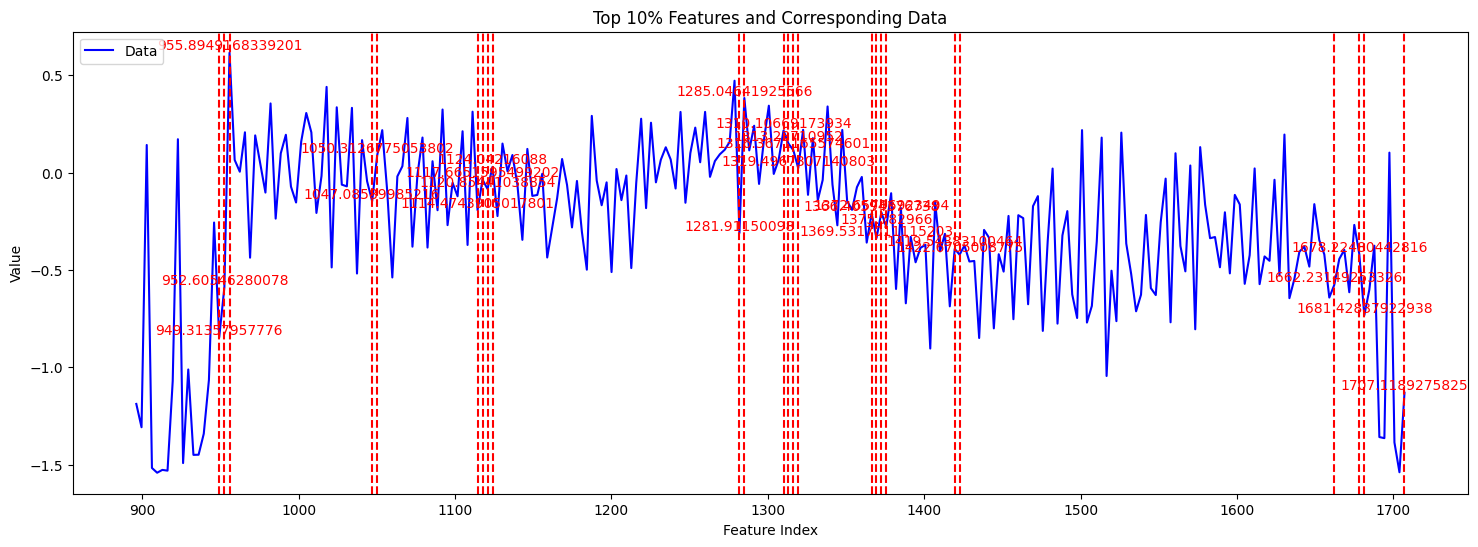

In [ ]:



csv_path ="./Classification_of_Varieties/vis/processed_spectra.csv"
df =pd .read_csv (csv_path )


wavelength =eval (df .iloc [0 ]['wavelength'])


cam =deep_compute_gradcam (model ,input_tensor ,target_class )
data =input_tensor 


sample_index =0 
cam_sample =cam [sample_index ].cpu ().numpy ()
data_sample =data [sample_index ].cpu ().numpy ()


top_percentage =0.1 
num_top_features =int (len (cam_sample )*top_percentage )


top_indices =np .argsort (cam_sample )[-num_top_features :]


plt .figure (figsize =(18 ,6 ))
plt .plot (wavelength ,data_sample ,label ='Data',color ='b')


for idx in top_indices :
    plt .axvline (x =wavelength [idx ],color ='r',linestyle ='--')
    plt .text (wavelength [idx ],data_sample [idx ],f'{wavelength[idx]}',color ='r',fontsize =10 ,ha ='center',va ='bottom')

plt .title ('Top 10% Features and Corresponding Data')
plt .xlabel ('Feature Index')
plt .ylabel ('Value')
plt .legend ()
plt .savefig ('./Classification_of_Varieties/vis/cam-data.png',dpi =300 )




In [4]:
cam =cam .squeeze ().cpu ().numpy ()

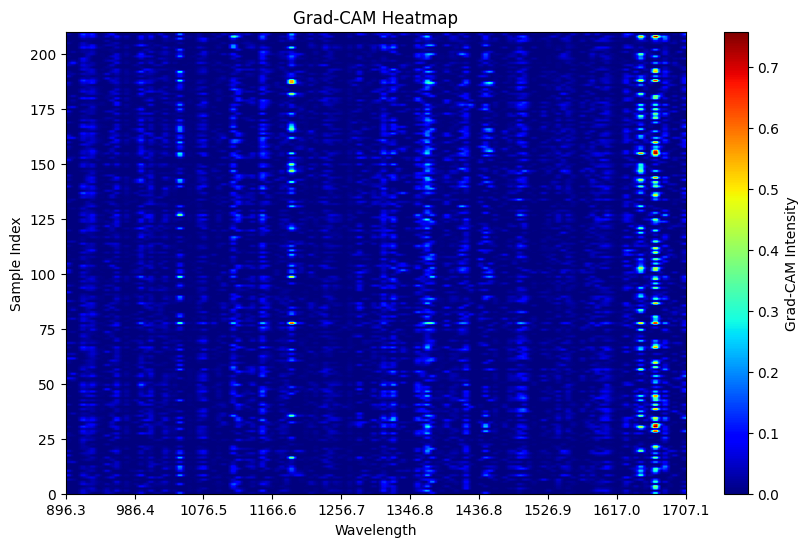

In [ ]:

custom_colors =['#274F7C','#00989D','#F368A0','#FFDDA7']
custom_cmap =mcolors .LinearSegmentedColormap .from_list ("custom_cmap",custom_colors ,N =256 )


plt .figure (figsize =(10 ,6 ))
plt .imshow (cam ,cmap ='jet',aspect ='auto',extent =[wavelength [0 ],wavelength [-1 ],0 ,cam .shape [0 ]])

plt .xticks (np .linspace (wavelength [0 ],wavelength [-1 ],num =10 ))

plt .colorbar (label ="Grad-CAM Intensity")

plt .xlabel ("Wavelength")
plt .ylabel ("Sample Index")
plt .title ("Grad-CAM Heatmap")


plt .show ()




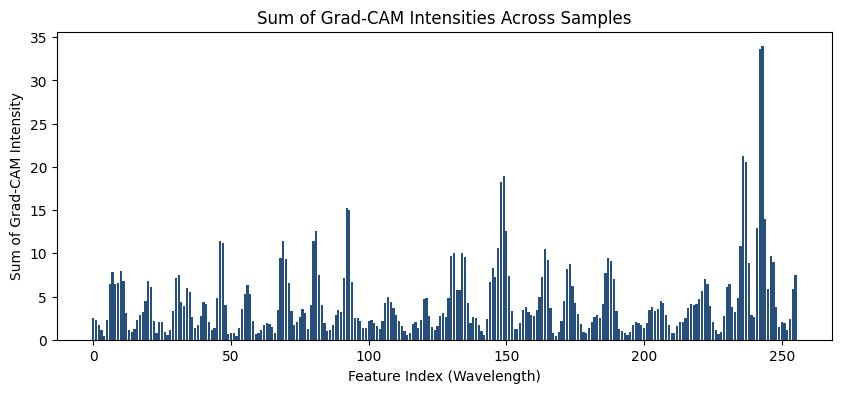

In [ ]:


column_sums =np .sum (cam ,axis =0 )


plt .figure (figsize =(10 ,4 ))
plt .bar (range (len (column_sums )),column_sums ,color ='#274F7C')
plt .xlabel ("Feature Index (Wavelength)")
plt .ylabel ("Sum of Grad-CAM Intensity")
plt .title ("Sum of Grad-CAM Intensities Across Samples")



plt .show ()


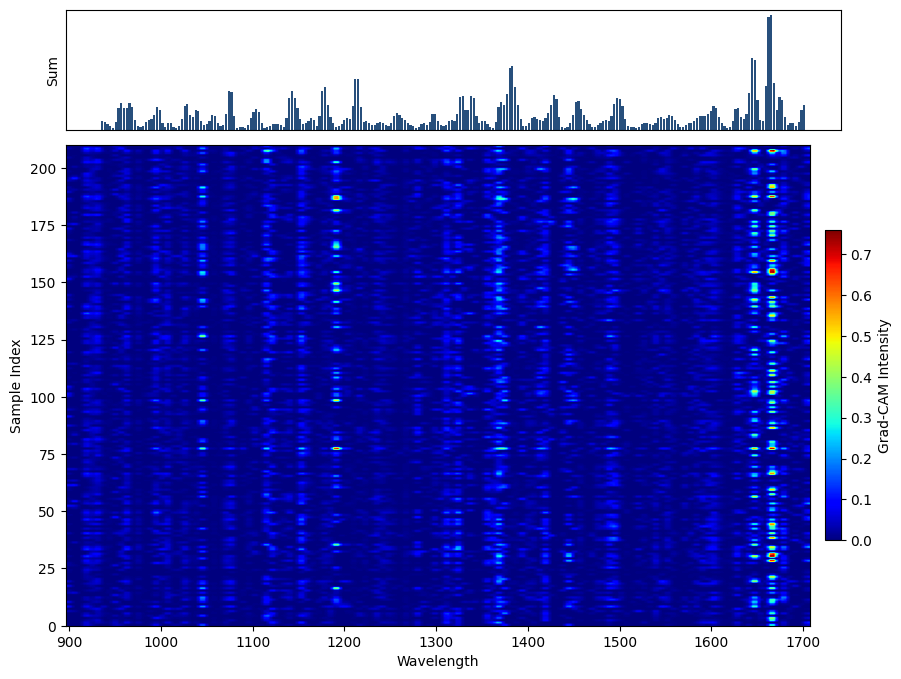

In [ ]:



column_sums =np .sum (cam ,axis =0 )


fig =plt .figure (figsize =(10 ,8 ))
gs =gridspec .GridSpec (2 ,1 ,height_ratios =[1 ,4 ],hspace =0.05 )


ax1 =plt .subplot (gs [0 ])
ax1 .bar (range (len (column_sums )),column_sums ,color ='#274F7C')
ax1 .set_xticks ([])
ax1 .set_yticks ([])
ax1 .set_ylabel ("Sum")


ax2 =plt .subplot (gs [1 ])
im =ax2 .imshow (cam ,cmap ='jet',aspect ='auto',extent =[wavelength [0 ],wavelength [-1 ],0 ,cam .shape [0 ]])
ax2 .set_xlabel ("Wavelength")
ax2 .set_ylabel ("Sample Index")


cbar =fig .colorbar (im ,ax =ax2 ,orientation ='vertical',fraction =0.02 ,pad =0.02 )
cbar .set_label ("Grad-CAM Intensity")



plt .show ()



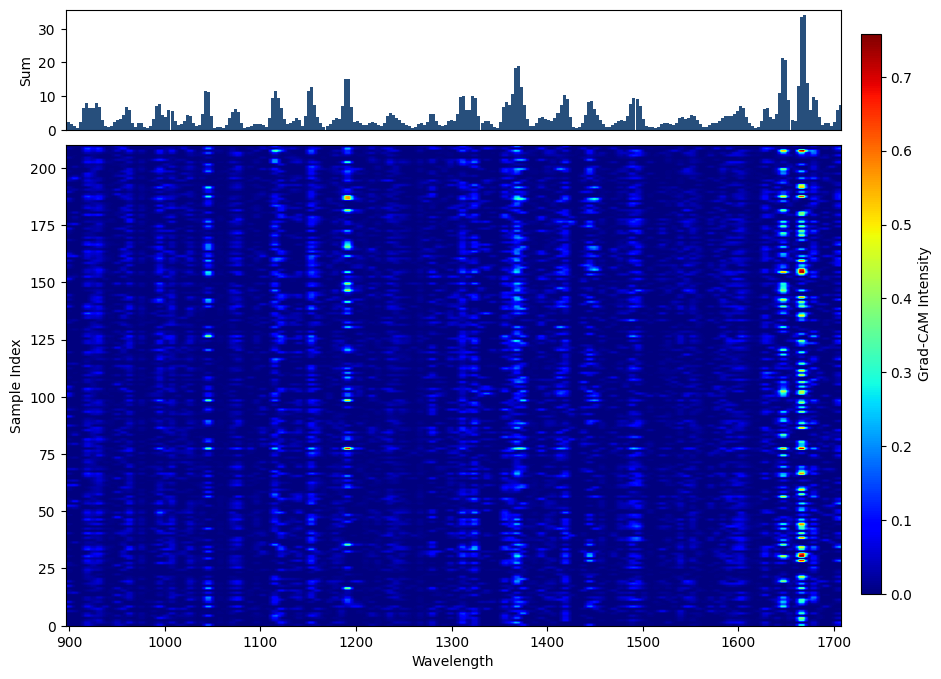

In [ ]:
import numpy as np 
import matplotlib .pyplot as plt 
import matplotlib .gridspec as gridspec 


column_sums =np .sum (cam ,axis =0 )


fig =plt .figure (figsize =(10 ,8 ))
gs =gridspec .GridSpec (2 ,1 ,height_ratios =[1 ,4 ],hspace =0.05 )


ax1 =plt .subplot (gs [0 ])
ax1 .bar (np .linspace (wavelength [0 ],wavelength [-1 ],num =len (column_sums )),column_sums ,color ='#274F7C',width =(wavelength [-1 ]-wavelength [0 ])/len (column_sums ))
ax1 .set_xlim ([wavelength [0 ],wavelength [-1 ]])
ax1 .set_xticks ([])
ax1 .set_ylabel ("Sum")


ax2 =plt .subplot (gs [1 ])
im =ax2 .imshow (cam ,cmap ='jet',aspect ='auto',extent =[wavelength [0 ],wavelength [-1 ],0 ,cam .shape [0 ]])
ax2 .set_xlabel ("Wavelength")
ax2 .set_ylabel ("Sample Index")



cbar_ax =fig .add_axes ([0.92 ,0.15 ,0.02 ,0.7 ])
cbar =fig .colorbar (im ,cax =cbar_ax )
cbar .set_label ("Grad-CAM Intensity")



plt .show ()


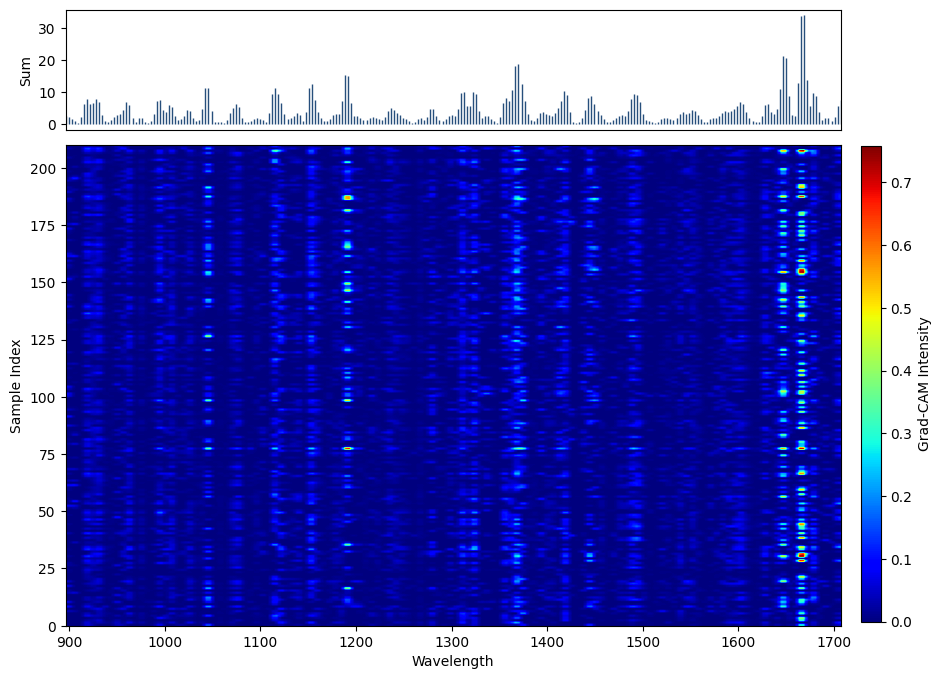

In [ ]:
import numpy as np 
import matplotlib .pyplot as plt 
import matplotlib .gridspec as gridspec 


column_sums =np .sum (cam ,axis =0 )


fig =plt .figure (figsize =(10 ,8 ))
gs =gridspec .GridSpec (2 ,1 ,height_ratios =[1 ,4 ],hspace =0.05 )


x_positions =np .linspace (wavelength [0 ],wavelength [-1 ],num =len (column_sums ))


ax1 =plt .subplot (gs [0 ])
ax1 .vlines (x_positions ,ymin =0 ,ymax =column_sums ,color ='#274F7C',linewidth =1 )
ax1 .set_xlim ([wavelength [0 ],wavelength [-1 ]])
ax1 .set_xticks ([])
ax1 .set_ylabel ("Sum")


ax2 =plt .subplot (gs [1 ])
im =ax2 .imshow (cam ,cmap ='jet',aspect ='auto',extent =[wavelength [0 ],wavelength [-1 ],0 ,cam .shape [0 ]])
ax2 .set_xlabel ("Wavelength")
ax2 .set_ylabel ("Sample Index")



cbar_ax =fig .add_axes ([0.92 ,0.115 ,0.02 ,0.595 ])
cbar =fig .colorbar (im ,cax =cbar_ax )
cbar .set_label ("Grad-CAM Intensity")



plt .show ()


(210, 256)


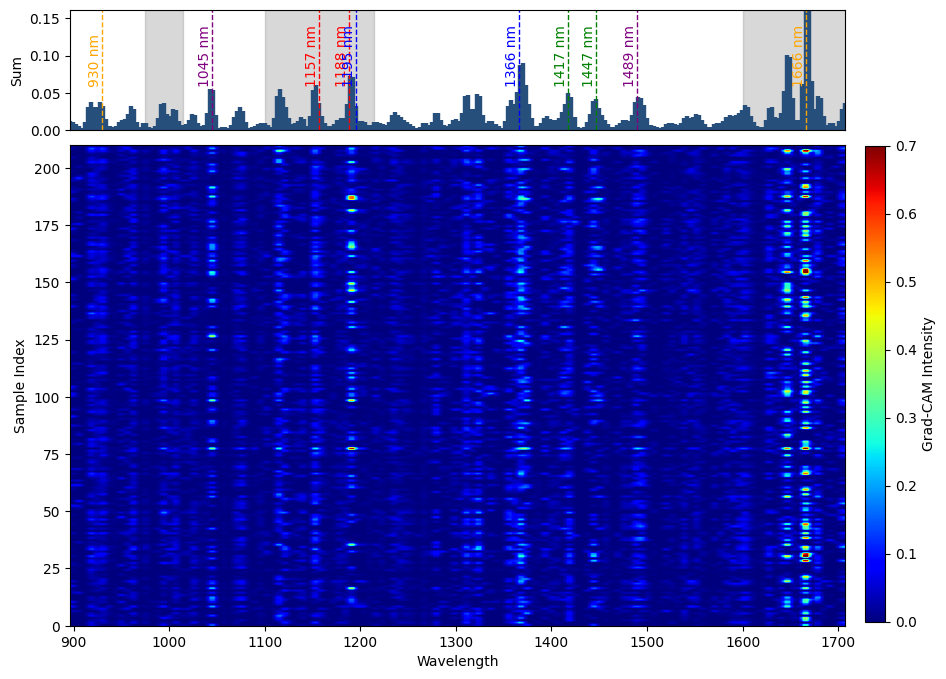

In [ ]:
import numpy as np 
import matplotlib .pyplot as plt 
import matplotlib .gridspec as gridspec 


column_sums =np .sum (cam ,axis =0 )
print (cam .shape )
column_sums =column_sums /cam .shape [0 ]

fig =plt .figure (figsize =(10 ,8 ))
gs =gridspec .GridSpec (2 ,1 ,height_ratios =[1 ,4 ],hspace =0.05 )


x_positions =np .linspace (wavelength [0 ],wavelength [-1 ],num =len (column_sums ))

"""
protein or peptide groups related absorption bands of 975–1015 nm (N-H stretch second overtone)
protein-related absorption bands 1480–1550 nm (N-H stretch first overtone)
1620–1700 nm (aromatic C-H stretch first overtone)
The wavelengths in the range of 1230–1400 nm could be attributed to C–H  second overtone

1045 combination of C–H stretching first overtone and C–H deformation first overtone of CH2
1157 2nd OT C-H str.
1188-1195 2nd OT C-H str.
1366 1st OT C-H str. + C-H def.
1417 1st OT C-H str. + C-H bend.
1447 1st OT O-H str.  phenolic oH group
Phenolic OH group  （–OH），（phenols） 。  （–OH） （benzene ring） 。
（Citrus） （phenolics），：
1477 1st OT O-H str. Intramolecular H-bond in cellulose
1489 1ST OT O-H str. Intramolecular H-bond in cellulose
Intramolecular H-bond in cellulose  （cellulose）（Intramolecular Hydrogen Bond）
1666 1st OT C-H str. CH3 groups
930 the third overtone associated with CH 2 stretching (930 nm),
the wavelengths between 1600 nm and 1800 nm were attributed to the first overtones of C–H stretching.
"""


red_lines_x =[1157 ,1188 ,1195 ,1366 ,1417 ,1447 ,1489 ,1045 ,930 ,1666 ]

colors =['red','blue','green','purple','orange','cyan','magenta','brown']
ax1 =plt .subplot (gs [0 ])
ax1 .vlines (x_positions ,ymin =0 ,ymax =column_sums ,color ='#274F7C',linewidth =(wavelength [-1 ]-wavelength [0 ])/len (column_sums ))

for i ,x in enumerate (red_lines_x ):
    color =colors [(i //2 )%len (colors )]
    ax1 .vlines (x ,ymin =0 ,ymax =np .max (column_sums ),color =color ,linewidth =1 ,linestyle ='--')
    ax1 .text (x ,np .max (column_sums )/2.8 ,f'{x} nm',rotation =90 ,verticalalignment ='bottom',
    horizontalalignment ='right',color =color )



ax1 .axvspan (1600 ,1800 ,color ='gray',alpha =0.3 )

ax1 .axvspan (1100 ,1214 ,color ='gray',alpha =0.3 )
ax1 .axvspan (975 ,1015 ,color ='gray',alpha =0.3 )

ax1 .set_ylim ([0 ,np .max (column_sums )])
ax1 .set_xlim ([wavelength [0 ],wavelength [-1 ]])
ax1 .set_xticks ([])
ax1 .set_ylabel ("Sum")


ax2 =plt .subplot (gs [1 ])
im =ax2 .imshow (cam ,cmap ='jet',aspect ='auto',extent =[wavelength [0 ],wavelength [-1 ],0 ,cam .shape [0 ]],vmin =0 ,vmax =0.7 )
ax2 .set_xlabel ("Wavelength")
ax2 .set_ylabel ("Sample Index")



cbar_ax =fig .add_axes ([0.92 ,0.115 ,0.02 ,0.595 ])
cbar =fig .colorbar (im ,cax =cbar_ax )
cbar .set_label ("Grad-CAM Intensity")




plt .savefig ("./Classification_of_Varieties/all_images/exp-global-MG-NIRL.png",dpi =900 )


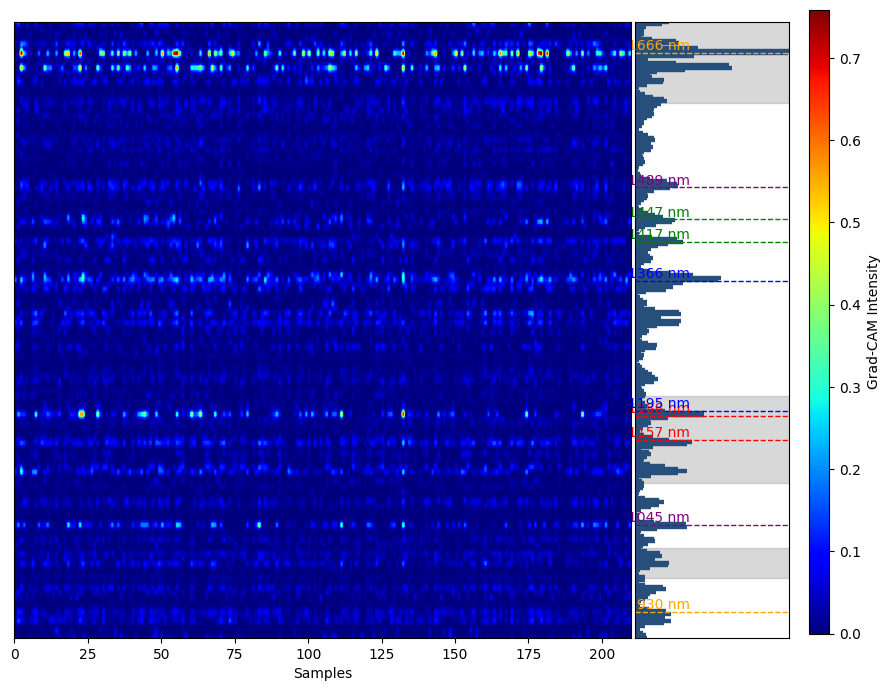

In [11]:
import numpy as np 
import matplotlib .pyplot as plt 
import matplotlib .gridspec as gridspec 


column_sums =np .sum (cam ,axis =0 )
column_sums =column_sums /cam .shape [0 ]


fig =plt .figure (figsize =(10 ,8 ))
gs =gridspec .GridSpec (1 ,2 ,width_ratios =[4 ,1 ],wspace =0.01 )


y_positions =np .linspace (wavelength [0 ],wavelength [-1 ],num =len (column_sums ))


red_lines_y =[1157 ,1188 ,1195 ,1366 ,1417 ,1447 ,1489 ,1045 ,930 ,1666 ]
colors =['red','blue','green','purple','orange','cyan','magenta','brown']

ax1 =plt .subplot (gs [1 ])
ax1 .hlines (y_positions ,xmin =0 ,xmax =column_sums ,color ='#274F7C',
linewidth =(wavelength [-1 ]-wavelength [0 ])/len (column_sums ))

for i ,y in enumerate (red_lines_y ):
    color =colors [(i //2 )%len (colors )]
    ax1 .hlines (y ,xmin =0 ,xmax =np .max (column_sums ),color =color ,linewidth =1 ,linestyle ='--')
    ax1 .text (np .max (column_sums )/2.8 ,y ,f'{y} nm',verticalalignment ='bottom',
    horizontalalignment ='right',color =color )


ax1 .axhspan (1600 ,1800 ,color ='gray',alpha =0.3 )
ax1 .axhspan (1100 ,1214 ,color ='gray',alpha =0.3 )
ax1 .axhspan (975 ,1015 ,color ='gray',alpha =0.3 )

ax1 .set_xlim ([0 ,np .max (column_sums )])

ax1 .set_ylim ([wavelength [0 ],wavelength [-1 ]])
ax1 .set_yticks ([])
ax1 .set_xticks ([])
ax1 .set_xticklabels ([])


ax2 =plt .subplot (gs [0 ])
im =ax2 .imshow (cam .T ,cmap ='jet',aspect ='auto',
extent =[0 ,cam .shape [0 ],wavelength [0 ],wavelength [-1 ]],
origin ='lower')

ax2 .set_xlabel ("Samples")
ax2 .set_yticks ([])
ax2 .set_yticklabels ([])


cbar_ax =fig .add_axes ([0.92 ,0.115 ,0.02 ,0.78 ])
cbar =fig .colorbar (im ,cax =cbar_ax )
cbar .set_label ("Grad-CAM Intensity")

plt .show ()


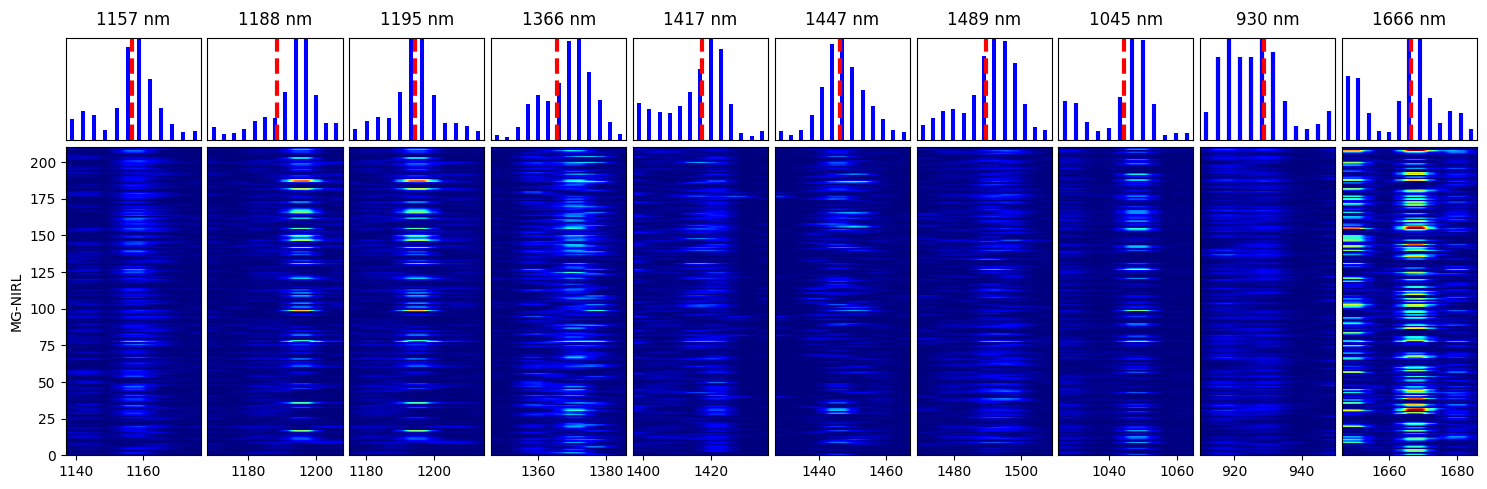

In [ ]:
import numpy as np 
import matplotlib .pyplot as plt 



wavelength =np .array (wavelength )


red_lines_x =[1157 ,1188 ,1195 ,1366 ,1417 ,1447 ,1489 ,1045 ,930 ,1666 ]


fig ,axes =plt .subplots (3 ,10 ,figsize =(15 ,5 ),gridspec_kw ={'height_ratios':[0.1 ,0.5 ,1.5 ]})



for i ,wavelength_value in enumerate (red_lines_x ):
    axes [0 ,i ].axis ("off")
    axes [0 ,i ].text (0.5 ,0.5 ,f"{wavelength_value} nm",fontsize =12 ,ha ="center",va ="center")



for i ,wavelength_value in enumerate (red_lines_x ):

    lower_bound =wavelength_value -20 
    upper_bound =wavelength_value +20 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )
    if np .any (idx_range ):
        selected_wavelengths =wavelength [idx_range ]
        corresponding_values =cam [:,idx_range ]
        summed_weights =np .sum (corresponding_values ,axis =0 )/cam .shape [0 ]


        axes [1 ,i ].vlines (selected_wavelengths ,0 ,summed_weights ,colors ='blue',linewidth =((selected_wavelengths [-1 ]-selected_wavelengths [0 ])/len (selected_wavelengths )))

        axes [1 ,i ].vlines (wavelength_value ,0 ,np .max (summed_weights ),colors ='red',linewidth =3 ,linestyle ="dashed")


        axes [1 ,i ].set_ylim (0 ,np .max (summed_weights ))

        axes [1 ,i ].set_yticks ([])
        axes [1 ,i ].set_ylabel ("")

        axes [1 ,i ].set_xticks ([])
        axes [1 ,i ].set_xlabel ("")

    else :
        axes [1 ,i ].axis ("off")





for i ,wavelength_value in enumerate (red_lines_x ):
    lower_bound =wavelength_value -20 
    upper_bound =wavelength_value +20 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )


    if np .any (idx_range ):
        heatmap_data =cam [:,idx_range ]


        im =axes [2 ,i ].imshow (heatmap_data ,cmap ='jet',aspect ='auto',vmin =0 ,vmax =0.7 ,
        extent =[lower_bound ,upper_bound ,0 ,cam .shape [0 ]])

    else :
        axes [2 ,i ].axis ("off")
    if i !=0 :
        axes [2 ,i ].set_yticks ([])
        axes [2 ,i ].set_ylabel ("")
    if i ==0 :
        axes [2 ,i ].set_ylabel ("MG-NIRL")

plt .tight_layout ()

plt .subplots_adjust (hspace =0.05 ,wspace =0.05 )

plt .savefig ("./Classification_of_Varieties/all_images/exp-MG-NRL.png",dpi =900 )


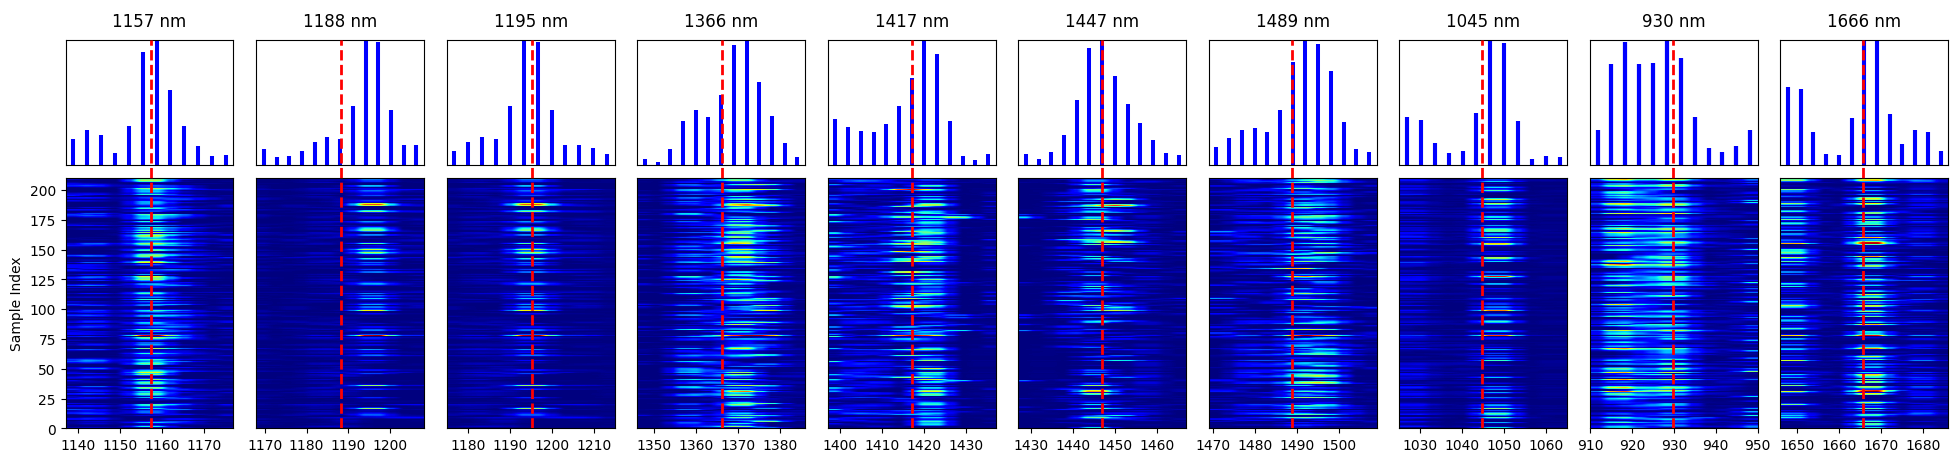

In [13]:
import numpy as np 
import matplotlib .pyplot as plt 
import matplotlib .patches as patches 


wavelength =np .array (wavelength )


red_lines_x =[1157 ,1188 ,1195 ,1366 ,1417 ,1447 ,1489 ,1045 ,930 ,1666 ]


fig ,axes =plt .subplots (3 ,10 ,figsize =(20 ,5 ),gridspec_kw ={'height_ratios':[0.1 ,1 ,2 ]})


for i ,wavelength_value in enumerate (red_lines_x ):
    axes [0 ,i ].axis ("off")
    axes [0 ,i ].text (0.5 ,0.5 ,f"{wavelength_value} nm",fontsize =12 ,ha ="center",va ="center")





for i ,wavelength_value in enumerate (red_lines_x ):
    lower_bound =wavelength_value -20 
    upper_bound =wavelength_value +20 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )

    if np .any (idx_range ):
        selected_wavelengths =wavelength [idx_range ]
        corresponding_values =cam [:,idx_range ]
        summed_weights =np .sum (corresponding_values ,axis =0 )/cam .shape [0 ]

        axes [1 ,i ].vlines (selected_wavelengths ,0 ,summed_weights ,colors ='blue',
        linewidth =((selected_wavelengths [-1 ]-selected_wavelengths [0 ])/len (selected_wavelengths )))


        axes [1 ,i ].set_ylim (0 ,np .max (summed_weights ))

        axes [1 ,i ].set_yticks ([])
        axes [1 ,i ].set_ylabel ("")
        axes [1 ,i ].set_xticks ([])
        axes [1 ,i ].set_xlabel ("")
    else :
        axes [1 ,i ].axis ("off")


for i ,wavelength_value in enumerate (red_lines_x ):
    lower_bound =wavelength_value -20 
    upper_bound =wavelength_value +20 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )

    if np .any (idx_range ):
        heatmap_data =cam [:,idx_range ]
        im =axes [2 ,i ].imshow (heatmap_data ,cmap ='jet',aspect ='auto',
        extent =[lower_bound ,upper_bound ,0 ,cam .shape [0 ]])
    else :
        axes [2 ,i ].axis ("off")

    if i !=0 :
        axes [2 ,i ].set_yticks ([])
        axes [2 ,i ].set_ylabel ("")
    if i ==0 :
        axes [2 ,i ].set_ylabel ("Sample Index")


ax =fig .add_subplot (111 ,frameon =False )
ax .tick_params (labelcolor ='none',top =False ,bottom =False ,left =False ,right =False )

for i ,wavelength_value in enumerate (red_lines_x ):
    ax .axvline (x =i ,ymin =0 ,ymax =0.94 ,color ='red',linestyle ="dashed",linewidth =2 )


plt .tight_layout ()
plt .subplots_adjust (hspace =0.1 )
plt .show ()


(210, 256)


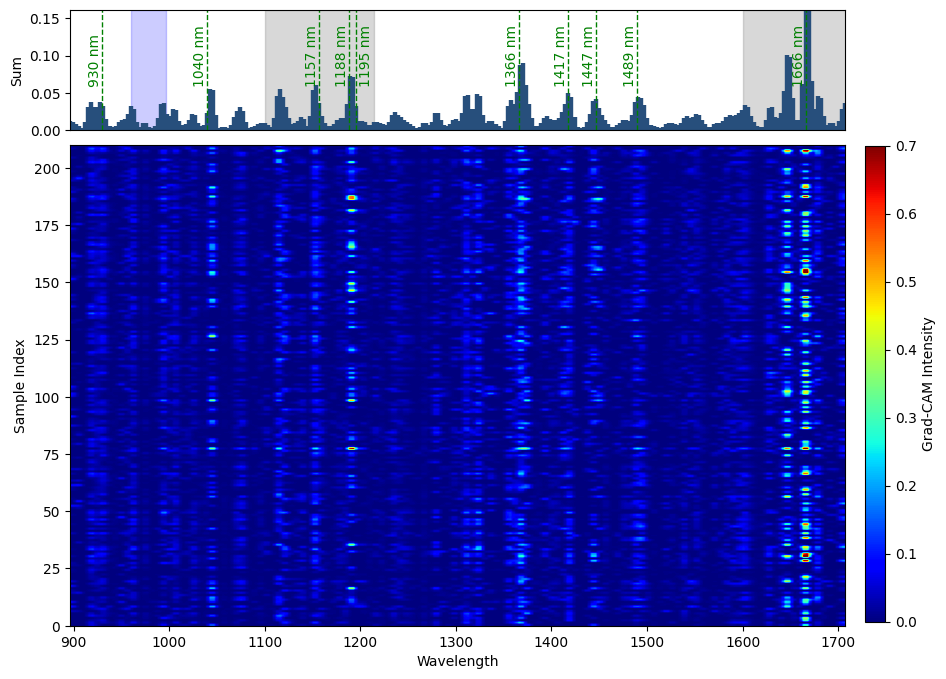

In [ ]:
import numpy as np 
import matplotlib .pyplot as plt 
import matplotlib .gridspec as gridspec 


column_sums =np .sum (cam ,axis =0 )
print (cam .shape )
column_sums =column_sums /cam .shape [0 ]

fig =plt .figure (figsize =(10 ,8 ))
gs =gridspec .GridSpec (2 ,1 ,height_ratios =[1 ,4 ],hspace =0.05 )


x_positions =np .linspace (wavelength [0 ],wavelength [-1 ],num =len (column_sums ))


red_lines_x =[1157 ,1188 ,1195 ,1366 ,1417 ,1447 ,1489 ,1040 ,930 ,1666 ]

colors =['green','green','green','green','green','green','green','green']
ax1 =plt .subplot (gs [0 ])
ax1 .vlines (x_positions ,ymin =0 ,ymax =column_sums ,color ='#274F7C',linewidth =(wavelength [-1 ]-wavelength [0 ])/len (column_sums ))



ax1 .axvspan (1600 ,1800 ,color ='gray',alpha =0.3 )

ax1 .axvspan (1100 ,1214 ,color ='gray',alpha =0.3 )

ax1 .axvspan (960 ,997 ,color ='blue',alpha =0.2 )




for i ,x in enumerate (red_lines_x ):
    color =colors [(i //2 )%len (colors )]
    ax1 .vlines (x ,ymin =0 ,ymax =np .max (column_sums ),color =color ,linewidth =1 ,linestyle ='--')
    if x ==1195 :
        ax1 .text (x +4 ,np .max (column_sums )/2.8 ,f'{x} nm',rotation =90 ,verticalalignment ='bottom',
        horizontalalignment ='left',color =color )
    else :
        ax1 .text (x ,np .max (column_sums )/2.8 ,f'{x} nm',rotation =90 ,verticalalignment ='bottom',
        horizontalalignment ='right',color =color )

ax1 .set_ylim ([0 ,np .max (column_sums )])
ax1 .set_xlim ([wavelength [0 ],wavelength [-1 ]])
ax1 .set_xticks ([])
ax1 .set_ylabel ("Sum")


ax2 =plt .subplot (gs [1 ])
im =ax2 .imshow (cam ,cmap ='jet',aspect ='auto',extent =[wavelength [0 ],wavelength [-1 ],0 ,cam .shape [0 ]],vmin =0 ,vmax =0.7 )
ax2 .set_xlabel ("Wavelength")
ax2 .set_ylabel ("Sample Index")



cbar_ax =fig .add_axes ([0.92 ,0.115 ,0.02 ,0.595 ])
cbar =fig .colorbar (im ,cax =cbar_ax )
cbar .set_label ("Grad-CAM Intensity")




plt .savefig ("./Classification_of_Varieties/all_images/exp-global-MG-NIRL.png",dpi =900 )


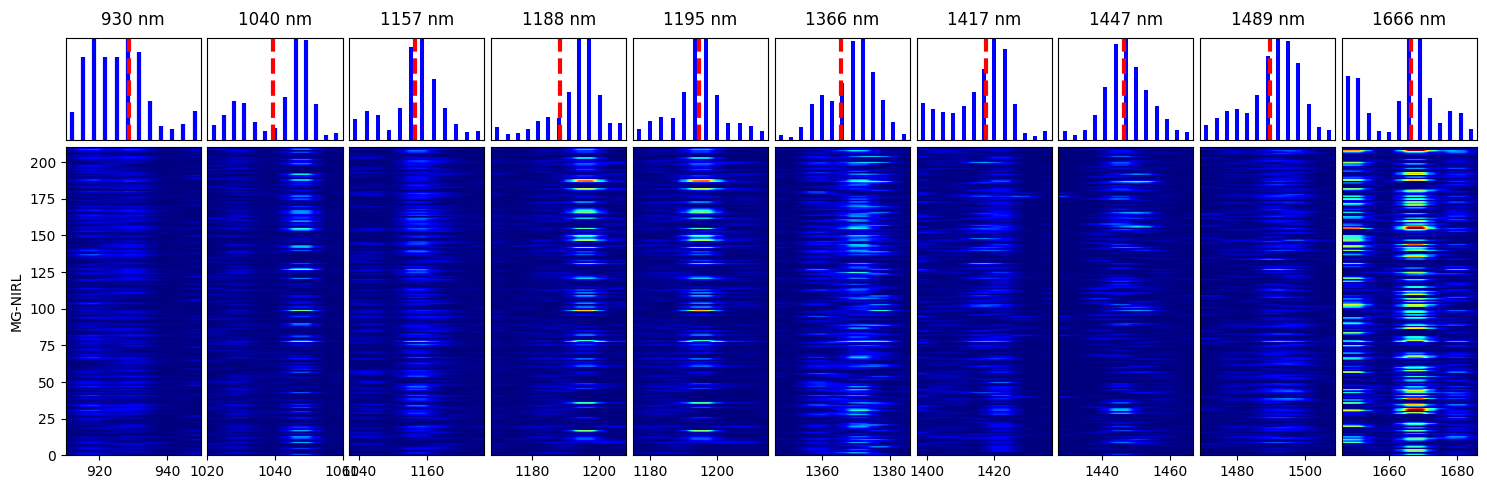

In [ ]:
import numpy as np 
import matplotlib .pyplot as plt 



wavelength =np .array (wavelength )



red_lines_x =[930 ,1040 ,1157 ,1188 ,1195 ,1366 ,1417 ,1447 ,1489 ,1666 ]


fig ,axes =plt .subplots (3 ,10 ,figsize =(15 ,5 ),gridspec_kw ={'height_ratios':[0.1 ,0.5 ,1.5 ]})



for i ,wavelength_value in enumerate (red_lines_x ):
    axes [0 ,i ].axis ("off")
    axes [0 ,i ].text (0.5 ,0.5 ,f"{wavelength_value} nm",fontsize =12 ,ha ="center",va ="center")



for i ,wavelength_value in enumerate (red_lines_x ):

    lower_bound =wavelength_value -20 
    upper_bound =wavelength_value +20 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )
    if np .any (idx_range ):
        selected_wavelengths =wavelength [idx_range ]
        corresponding_values =cam [:,idx_range ]
        summed_weights =np .sum (corresponding_values ,axis =0 )/cam .shape [0 ]


        axes [1 ,i ].vlines (selected_wavelengths ,0 ,summed_weights ,colors ='blue',linewidth =((selected_wavelengths [-1 ]-selected_wavelengths [0 ])/len (selected_wavelengths )))

        axes [1 ,i ].vlines (wavelength_value ,0 ,np .max (summed_weights ),colors ='red',linewidth =3 ,linestyle ="dashed")


        axes [1 ,i ].set_ylim (0 ,np .max (summed_weights ))

        axes [1 ,i ].set_yticks ([])
        axes [1 ,i ].set_ylabel ("")

        axes [1 ,i ].set_xticks ([])
        axes [1 ,i ].set_xlabel ("")



    else :
        axes [1 ,i ].axis ("off")





for i ,wavelength_value in enumerate (red_lines_x ):
    lower_bound =wavelength_value -20 
    upper_bound =wavelength_value +20 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )


    if np .any (idx_range ):
        heatmap_data =cam [:,idx_range ]


        im =axes [2 ,i ].imshow (heatmap_data ,cmap ='jet',aspect ='auto',vmin =0 ,vmax =0.7 ,
        extent =[lower_bound ,upper_bound ,0 ,cam .shape [0 ]])

    else :
        axes [2 ,i ].axis ("off")
    if i !=0 :
        axes [2 ,i ].set_yticks ([])
        axes [2 ,i ].set_ylabel ("")
    if i ==0 :
        axes [2 ,i ].set_ylabel ("MG-NIRL")


plt .tight_layout ()

plt .subplots_adjust (hspace =0.05 ,wspace =0.05 )

plt .savefig ("./Classification_of_Varieties/all_images/exp-MG-NRL.png",dpi =900 )


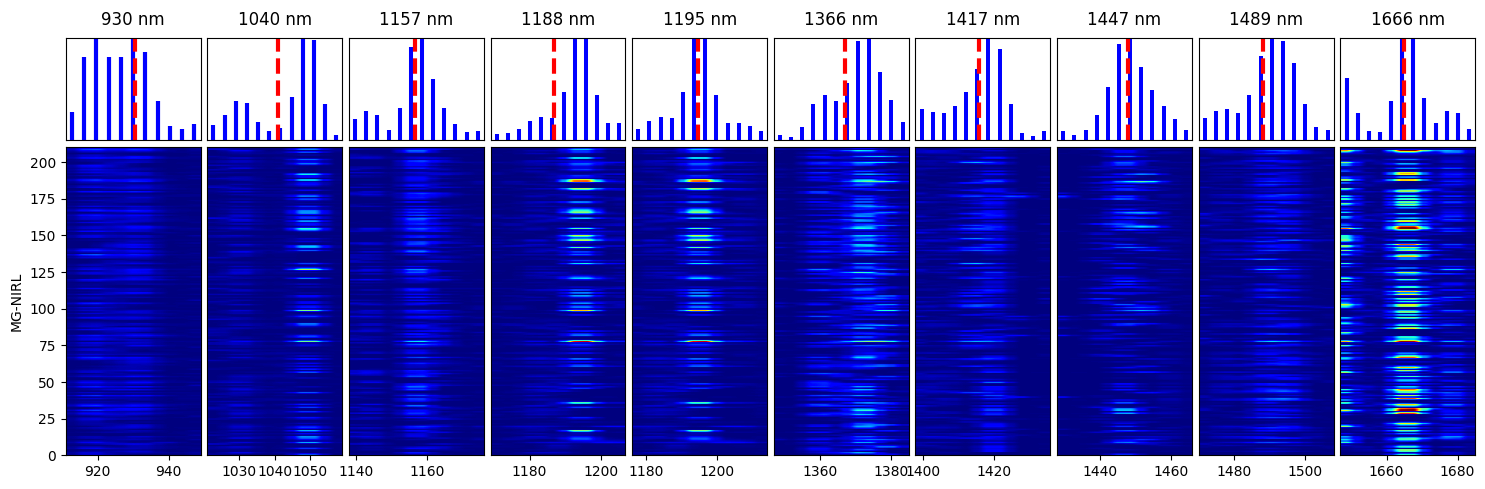

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np 
import matplotlib .pyplot as plt 



wavelength =np .array (wavelength )



red_lines_x =[930 ,1040 ,1157 ,1188 ,1195 ,1366 ,1417 ,1447 ,1489 ,1666 ]


fig ,axes =plt .subplots (3 ,10 ,figsize =(15 ,5 ),gridspec_kw ={'height_ratios':[0.1 ,0.5 ,1.5 ]})



for i ,wavelength_value in enumerate (red_lines_x ):
    axes [0 ,i ].axis ("off")
    axes [0 ,i ].text (0.5 ,0.5 ,f"{wavelength_value} nm",fontsize =12 ,ha ="center",va ="center")



for i ,wavelength_value in enumerate (red_lines_x ):

    lower_bound =wavelength_value -19 
    upper_bound =wavelength_value +19 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )
    if np .any (idx_range ):
        selected_wavelengths =wavelength [idx_range ]
        corresponding_values =cam [:,idx_range ]
        summed_weights =np .sum (corresponding_values ,axis =0 )/cam .shape [0 ]


        axes [1 ,i ].vlines (selected_wavelengths ,0 ,summed_weights ,colors ='blue',linewidth =((selected_wavelengths [-1 ]-selected_wavelengths [0 ])/len (selected_wavelengths )))

        axes [1 ,i ].vlines (wavelength_value ,0 ,np .max (summed_weights ),colors ='red',linewidth =3 ,linestyle ="dashed")


        axes [1 ,i ].set_ylim (0 ,np .max (summed_weights ))

        axes [1 ,i ].set_yticks ([])
        axes [1 ,i ].set_ylabel ("")

        axes [1 ,i ].set_xticks ([])
        axes [1 ,i ].set_xlabel ("")



    else :
        axes [1 ,i ].axis ("off")





for i ,wavelength_value in enumerate (red_lines_x ):
    lower_bound =wavelength_value -19 
    upper_bound =wavelength_value +19 
    idx_range =(wavelength >=lower_bound )&(wavelength <=upper_bound )


    if np .any (idx_range ):
        heatmap_data =cam [:,idx_range ]


        im =axes [2 ,i ].imshow (heatmap_data ,cmap ='jet',aspect ='auto',vmin =0 ,vmax =0.7 ,
        extent =[lower_bound ,upper_bound ,0 ,cam .shape [0 ]])

    else :
        axes [2 ,i ].axis ("off")
    if i !=0 :
        axes [2 ,i ].set_yticks ([])
        axes [2 ,i ].set_ylabel ("")
    if i ==0 :
        axes [2 ,i ].set_ylabel ("MG-NIRL")




plt .tight_layout ()

plt .subplots_adjust (hspace =0.05 ,wspace =0.05 )

plt .savefig ("./Classification_of_Varieties/all_images/exp-MG-NRL.png",dpi =900 )
